# **Capstone: Marketing and Retail Analytics**

## *Background and Problem Statement:*
OList, an e-commerce company has faced some losses recently and they want to reduce any unnecessary inventory costs.

To manage the inventory cost of the company OList, it is required to <br> 
identify top products contributing to the revenue, <br> 
identify items that are more likely to be purchased individually or in combination with some other products, <br> 
identify the product categories which they can get rid of without significantly impacting business.

Disclaimer: <br>
Only the cases having order status as 'delivered' are considered. <br>
EDA is performed to treat outliers and missing values carefully before making any inferences from the dataset.

### Steps to follow:

1. Read the dataset (orders, order_items, customers, payments, products).
2. Merge all the tables to make one data table.
3. Filter for only 'delivered' orders.
4. Understand the data (Shape, Data types, High level Statistics/Distribution, Unique Values etc).
5. Clean the dataset for Missing values, Duplicate values, Outliers and Consistencies.
6. Analyze the data: Univariate, Bivariate, Multivariate, Business specific.
7. Document Insights.
8. Export the cleaned and preprocessed dataset to a new table for Tableau Visualization & Dashboarding.

### Retail Dataset ERD

This is how the various tables in the dataset are associated with each other.

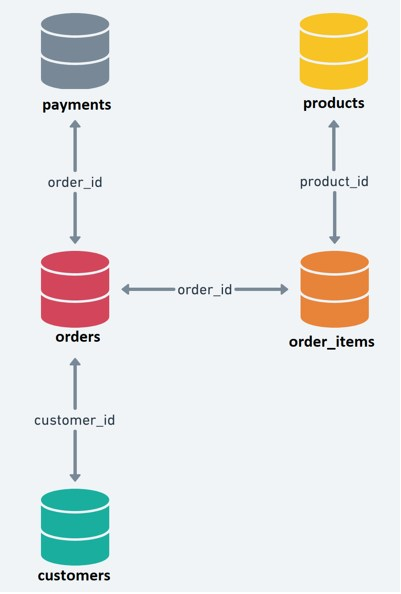

## 0. Import required libraries

In [34]:
# libaries for numerical operations and handling dataframes
import numpy as np, pandas as pd

# libraries to plot various graphs for data analysis
import matplotlib.pyplot as plt, seaborn as sns

# to plot and save graphs within jupyter notebook
%matplotlib inline

# disable warnings
import warnings
warnings.filterwarnings('ignore')


## 1. Read the dataset (orders, order_items, customers, payments, products)
orders:   
order_items:   
customers:   
payments:   
products:   

### orders

In [87]:
# read orders table from the retail dataset
orders = pd.read_excel('Retail_dataset.xlsx', sheet_name='orders')
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_timestamp,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,af07308b275d755c9edb36a90c618231,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,3a653a41f6f9fc3d2a113cf8398680e8,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,7c142cf63193a1473d2e66489a9ae977,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,72632f0f9dd73dfee390c9b22eb56dd6,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-16 18:17:02,2018-02-26


In [88]:
# check number of records and features in orders table
print('Records: {}\nFeatures: {}'.format(orders.shape[0], orders.shape[1]))

Records: 99441
Features: 7


In [89]:
# Check how many records in orders table have order_status other than 'delivered'
orders[orders.order_status != 'delivered'].shape

(2963, 7)

In [90]:
# Only the 'delivered' orders need to be considered according to the problem statement
orders = orders[orders.order_status == 'delivered']
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_timestamp,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,af07308b275d755c9edb36a90c618231,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,3a653a41f6f9fc3d2a113cf8398680e8,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,7c142cf63193a1473d2e66489a9ae977,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,72632f0f9dd73dfee390c9b22eb56dd6,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-16 18:17:02,2018-02-26


In [91]:
# check number of records and features in orders table, with only 'delivered' orders
print('Records: {}\nFeatures: {}'.format(orders.shape[0], orders.shape[1]))

Records: 96478
Features: 7


In [92]:
# no more orders other than 'delivered'
# orders[orders.order_status != 'delivered']

In [93]:
# drop order_status column as it is no more relevant
orders.drop(columns=['order_status'], axis=1, inplace=True)
orders = orders.reset_index(drop=True)
orders.head()

,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_timestamp,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-16 18:17:02,2018-02-26


In [94]:
# check number of records and features in orders table, excluding order_status column
print('Records: {}\nFeatures: {}'.format(orders.shape[0], orders.shape[1]))

Records: 96478
Features: 6


In [95]:
# Look at basic information of orders table
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96478 entries, 0 to 96477
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       96478 non-null  object        
 1   customer_id                    96478 non-null  object        
 2   order_purchase_timestamp       96478 non-null  datetime64[ns]
 3   order_approved_at              96464 non-null  datetime64[ns]
 4   order_delivered_timestamp      96470 non-null  datetime64[ns]
 5   order_estimated_delivery_date  96478 non-null  datetime64[ns]
dtypes: datetime64[ns](4), object(2)
memory usage: 4.4+ MB


In [96]:
# Observations:
# 1. The order_id and customer_id columns have object datatype which seems correct.
# 2. The timestamp related columns have datetime64[ns] datatype which also seems fine.
# 3. There are two timestamp columns with some null values.

In [97]:
# Look at basic numerical statistics of orders table
# Only numeric columns are datetime columns, and dates statistics is not relevant
# orders.describe()

In [98]:
# Check null values in orders table
(orders.isna().sum() / orders.size) * 100

order_id                         0.000000
customer_id                      0.000000
order_purchase_timestamp         0.000000
order_approved_at                0.002419
order_delivered_timestamp        0.001382
order_estimated_delivery_date    0.000000
dtype: float64

In [99]:
# Look at the null value records in 'order_approved_at' column
# orders[orders.order_approved_at.isna()].size

In [100]:
# Look at the null value records in 'order_delivered_timestamp' column
# orders[orders.order_delivered_timestamp.isna()].size

In [101]:
# Very low percentage of records in 'order_approved_at' and 'order_delivered_timestamp' have null values (NaT)
# These records can be discarded

# Remove missing value records column-by-column
# orders.order_approved_at.dropna(ignore_index=True, inplace=True)
# orders.order_delivered_timestamp.dropna(ignore_index=True, inplace=True)

# OR
# Remove missing value records in the whole table
orders.dropna(ignore_index=True, inplace=True)

In [102]:
# Check null values in orders table, after treating null value records in 2 columns
orders.isna().sum()

order_id                         0
customer_id                      0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_timestamp        0
order_estimated_delivery_date    0
dtype: int64

In [103]:
# check number of records and features in orders table, after treating null values in 2 columns
print('Records: {}\nFeatures: {}'.format(orders.shape[0], orders.shape[1]))

Records: 96456
Features: 6


In [155]:
# Look for any duplicate records in orders table
orders[orders.duplicated()]

# Remove duplicates
# orders.drop_duplicates()

,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_timestamp,order_estimated_delivery_date


In [182]:
# Check if purchase dates are appearing after the delivery dates
orders[orders.order_purchase_timestamp > orders.order_delivered_timestamp].size

0

In [183]:
# Check if purchase dates are appearing after the approval dates
orders[orders.order_purchase_timestamp > orders.order_approved_at].size

0

In [195]:
# Any Deliveries faster than Estimation?
FastDeliveries = orders[orders.order_delivered_timestamp < orders.order_estimated_delivery_date].size
print('%age of Fast Deliveries: ', (FastDeliveries / orders.size)*100)

%age of Fast Deliveries:  91.88645600066351


In [194]:
# Any Deliveries slower than Estimation?
SlowDeliveries = orders[orders.order_delivered_timestamp > orders.order_estimated_delivery_date].size
print('%age of Slow Deliveries: ', (SlowDeliveries / orders.size)*100)

%age of Slow Deliveries:  8.113543999336486


In [186]:
# Any Deliveries macthing Estimation?
orders[orders.order_delivered_timestamp == orders.order_estimated_delivery_date].size

0

In [197]:
# Observations:
# 1. Purchase, Approval and Delivery dates are consistent with each other
# 2. No order is delivered as estimated
# 3. In approx 92% orders, the deliveries are done before the estimations

In [383]:
# Check if all order_id values are unique in the orders table
orders.order_id.nunique() == orders.shape[0]

True

In [104]:
###############################################################################

### order_items

In [105]:
# read order_items table from the retail dataset
items = pd.read_excel('Retail_dataset.xlsx', sheet_name='order_items')
items.head()

,order_id,order_item_id,product_id,seller_id,price,shipping_charges
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,199.90,18.14


In [106]:
# check number of records and features in order_items table
print('Records: {}\nFeatures: {}'.format(items.shape[0], items.shape[1]))

Records: 112650
Features: 6


In [107]:
# Look at basic information of order_items table
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   order_id          112650 non-null  object 
 1   order_item_id     112650 non-null  int64  
 2   product_id        112650 non-null  object 
 3   seller_id         112650 non-null  object 
 4   price             112650 non-null  float64
 5   shipping_charges  112650 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 5.2+ MB


In [108]:
# Observations:
# 1. The order_id, product_id and seller_id columns have object datatype which seems correct.
# 2. The order_item_id column has integer datatype which is fine too.
# 3. The price and shipping_charges columns have float datatype which is also correct.
# 4. There are no columns with null values.

In [113]:
# Look at basic numerical statistics of order_items table
items.describe(percentiles=[0.75, 0.8, 0.85, 0.9, 0.95, 0.99])

,order_item_id,price,shipping_charges
count,112650.000000,112650.000000,112650.000000
mean,1.197834,120.653739,19.990320
std,0.705124,183.633928,15.806405
min,1.000000,0.850000,0.000000
50%,1.000000,74.990000,16.260000
75%,1.000000,134.900000,21.150000
80%,1.000000,150.000000,23.280000
85%,1.000000,179.990000,26.576500
90%,2.000000,229.800000,34.041000
95%,2.000000,349.900000,45.120000


In [201]:
# Observations:
# 1. There are order IDs with as many as 21 items ordered, which is a possible scenario
# 2. The price and shipping charges also varying as per the number of items in orders

In [174]:
# Check the order ID for item id 21
# items.loc[items.order_item_id==21, 'order_id']

In [175]:
# Check if there are consistent number of items in that order
# items.loc[items.order_id=='8272b63d03f5f79c56e9e4120aec44ef']

In [177]:
# Check null values in order_items table
(items.isna().sum() / items.size) * 100

order_id            0.0
order_item_id       0.0
product_id          0.0
seller_id           0.0
price               0.0
shipping_charges    0.0
dtype: float64

In [ ]:
# Observations:
# 1. No columns with null values

In [179]:
# Look for any duplicate records in order_items table
items[items.duplicated()]

# Remove duplicates
# items.drop_duplicates()

,order_id,order_item_id,product_id,seller_id,price,shipping_charges


In [199]:
# Any orders with shipping cost more than the product price?
HigherShipping = items[items.shipping_charges > items.price].size
print('%age of Higher Shippings: ', (HigherShipping / items.size)*100)

%age of Higher Shippings:  3.6608965823346646


In [200]:
# Observations:
# 1. A little less than 4% of the orders had shipping charge more than the order price

In [395]:
# Check uniqueness in the primary key that's composed of order_id and order_item_id features
items[items.duplicated(subset=['order_id', 'order_item_id'])]

,order_id,order_item_id,product_id,seller_id,price,shipping_charges


In [202]:
###############################################################################

### customers

In [215]:
# read customers table from the retail dataset
customers = pd.read_excel('Retail_dataset.xlsx', sheet_name='customers')
customers.head()

,customer_id,customer_zip_code_prefix,customer_city,customer_state
0,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [216]:
# check number of records and features in customers table
print('Records: {}\nFeatures: {}'.format(customers.shape[0], customers.shape[1]))

Records: 99441
Features: 4


In [217]:
# Look at basic information of customers table
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_zip_code_prefix  99441 non-null  int64 
 2   customer_city             99441 non-null  object
 3   customer_state            99441 non-null  object
dtypes: int64(1), object(3)
memory usage: 3.0+ MB


In [ ]:
# Insights:
# 1. All datatypes seem correct.
# 2. There is no column with null values.

In [207]:
# Look at basic numerical statistics of customers table
# Only numeric column is 'customer_zip_code_prefix' for which numeric description is not necessary.
# customers.describe(percentiles=[0.75, 0.8, 0.85, 0.9, 0.95, 0.99])

In [218]:
# Check null values in customers table
# (customers.isna().sum() / customers.size) * 100

In [ ]:
# Remove missing value records in the whole table
# customers.dropna(ignore_index=True, inplace=True)

In [ ]:
# Check null values in customers table, after treating null value records in 2 columns
# customers.isna().sum()

In [209]:
# Look for any duplicate records in customers table
customers[customers.duplicated()]

,customer_id,customer_zip_code_prefix,customer_city,customer_state
679,b6c083700ca8c135ba9f0f132930d4e8,8686,suzano,SP
1463,a40096fc0a3862e9e12bc55b5f8e6ab2,20561,rio de janeiro,RJ
1607,b8b3c435a58aebd788a477bed8342910,95585,arroio do sal,RS
2811,66980c3775537536f77b434d74e520f5,30290,belo horizonte,MG
3198,788313d21c3507fe890921f6e17aa679,11070,santos,SP
...,...,...,...,...
99318,4c116f8ddec984371284ab7bc860001a,79500,paranaiba,MS
99320,08f7cf00ed9ff3e0a08fc136ec272974,71900,brasilia,DF
99324,8bab3162259edfaadd1ea2e1fe7f58dc,31565,belo horizonte,MG
99327,12ab9334b1240d6d037f2b0102a49571,38050,uberaba,MG


In [ ]:
# Insights:
# 1. More than 3000 records have some duplicacy that needs to be checked and fixed.

In [228]:
# Remove duplicates while adjusting the index
customers.drop_duplicates(inplace=True, ignore_index=True)

In [229]:
# Look for any duplicate records left
customers[customers.duplicated()]

,customer_id,customer_zip_code_prefix,customer_city,customer_state


In [265]:
# check number of records and features in customers table, after duplicates treatment
print('Records: {}\nFeatures: {}'.format(customers.shape[0], customers.shape[1]))

Records: 96352
Features: 4


In [263]:
# Check if duplicates present in customer_id field
customers[customers.duplicated(subset='customer_id')]

,customer_id,customer_zip_code_prefix,customer_city,customer_state
6120,3e43e6105506432c953e165fb2acf44c,11700,praia grande,SP
8339,b26fa76ddf33e534491e4ec46f51bc64,29010,vitoria,ES
11149,2b952792a20f6076f6e7a9c6a27ade02,13315,cabreuva,SP
14994,340d924858c395848c127b3e772b6bfd,31560,belo horizonte,MG
15192,1291474366a550ebc251d9187e763d62,12239,sao jose dos campos,SP
...,...,...,...,...
96108,408aee96c75632a92e5079eee61da399,22260,rio de janeiro,RJ
96148,13abc50b97af7425b5066e405d7cd760,7793,cajamar,SP
96214,bc7b9e0d078c0c01f622b38cfcd7ee9c,20521,rio de janeiro,RJ
96264,0ceb502fc33a2ad327b08288c5310e2e,29134,viana,ES


In [264]:
# Insights:
# 1. There are more than 250 records where customer_id is duplicated
# Note: Other features might not be duplicated

In [271]:
# Check duplicate customer ids for a random subset of customers table
cusDuplSubset = customers.iloc[0:15000, :]
cusDuplSubset[cusDuplSubset.duplicated(subset='customer_id', keep=False)] # exclude no duplicates

,customer_id,customer_zip_code_prefix,customer_city,customer_state
4603,2b952792a20f6076f6e7a9c6a27ade02,13250,itatiba,SP
5105,3e43e6105506432c953e165fb2acf44c,11701,praia grande,SP
5936,b26fa76ddf33e534491e4ec46f51bc64,29043,vitoria,ES
6120,3e43e6105506432c953e165fb2acf44c,11700,praia grande,SP
8230,340d924858c395848c127b3e772b6bfd,31995,belo horizonte,MG
8339,b26fa76ddf33e534491e4ec46f51bc64,29010,vitoria,ES
11149,2b952792a20f6076f6e7a9c6a27ade02,13315,cabreuva,SP
14994,340d924858c395848c127b3e772b6bfd,31560,belo horizonte,MG


In [ ]:
# Insights:
# 1. customer_id is supposed to be the primary key for the customers table, but there are some duplicate records found.
# 2. Any 2 records with same customer_id seem to have same state, but city and zip code might vary

In [272]:
# As customer_id is primary key for  customers table, duplicates can be removed
# Remove duplicates w.r.t customer_id column while adjusting the index
customers.drop_duplicates(subset='customer_id', inplace=True, ignore_index=True)

In [274]:
# Check if still any duplicates present in customer_id field
customers[customers.duplicated(subset='customer_id')]

,customer_id,customer_zip_code_prefix,customer_city,customer_state


In [387]:
# Check if all customer_id values are unique in the customers table
customers.customer_id.nunique() == customers.shape[0]

True

In [ ]:
###############################################################################

### payments

In [275]:
# read payments table from the retail dataset
payments = pd.read_excel('Retail_dataset.xlsx', sheet_name='payments')
payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [276]:
# check number of records and features in payments table
print('Records: {}\nFeatures: {}'.format(payments.shape[0], payments.shape[1]))

Records: 103886
Features: 5


In [277]:
# Look at basic information of payments table
payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [280]:
# Insights:
# 1. All datatypes seem correct.
# 2. There is no column with null values.

In [295]:
# Look at basic numerical statistics of payments table
# There is no relevance to look at numeric description of payment_sequential and payment_installments columns.
payments.payment_value.describe(percentiles=[0.75, 0.8, 0.85, 0.9, 0.95, 0.99, 0.995, 0.999])

count    103886.000000
mean        154.100380
std         217.494064
min           0.000000
50%         100.000000
75%         171.837500
80%         196.360000
85%         231.120000
90%         297.270000
95%         437.635000
99%        1039.916500
99.5%      1410.275750
99.9%      2339.233250
max       13664.080000
Name: payment_value, dtype: float64

In [ ]:
# Insights:
# 1. There are some orders with payment_value 0, which doesn't seem right.
# 2. The highest payment_value is greater than 13000 where as 99.9% of orders have payment_value within 2340.

In [297]:
# Look at orders with payment_value 0
payments[payments.payment_value==float(0)]

,order_id,payment_sequential,payment_type,payment_installments,payment_value
19922,8bcbe01d44d147f901cd3192671144db,4,voucher,1,0.0
36822,fa65dad1b0e818e3ccc5cb0e39231352,14,voucher,1,0.0
43744,6ccb433e00daae1283ccc956189c82ae,4,voucher,1,0.0
51280,4637ca194b6387e2d538dc89b124b0ee,1,not_defined,1,0.0
57411,00b1cb0320190ca0daa2c88b35206009,1,not_defined,1,0.0
62674,45ed6e85398a87c253db47c2d9f48216,3,voucher,1,0.0
77885,fa65dad1b0e818e3ccc5cb0e39231352,13,voucher,1,0.0
94427,c8c528189310eaa44a745b8d9d26908b,1,not_defined,1,0.0
100766,b23878b3e8eb4d25a158f57d96331b18,4,voucher,1,0.0


In [299]:
# Insights:
# 1. There are only 9 such orders where payment_value is 0.

In [298]:
# Look at orders with payment_value greater than 2340
payments[payments.payment_value>2340]

,order_id,payment_sequential,payment_type,payment_installments,payment_value
1139,80d49171762a51f500bf6b774aa24617,1,credit_card,1,2787.87
2161,0f924038b00d1f102e4d09bea4fa666a,1,credit_card,10,2759.95
2405,79d3522a0854c853a4979ff2691abd91,1,credit_card,10,3048.27
3251,66b9c991ee308f9342f6a7f63bb68251,1,credit_card,5,3358.24
3607,078f6a01964ee122ef20881df839af31,1,credit_card,10,2419.20
...,...,...,...,...,...
99960,9de73f3e6157169ad6c32b9f313c7dcb,1,credit_card,10,3899.00
102030,028558cddca332b40b4ac4cb77407edf,1,credit_card,10,2784.16
102654,acf01c9262ddb5d9adae8daa34e31568,1,credit_card,10,2416.00
103622,b0b0d3285e59abf2f6c9d7e1bf761323,1,credit_card,10,3044.12


In [ ]:
# Insights:
# 1. There are nearly 100 orders with payment_value greater than 2340.

In [301]:
# Check null values in payments table
# (payments.isna().sum() / payments.size) * 100

In [303]:
# Look for any duplicate records in payments table
payments[payments.duplicated()]

# Remove duplicates
# payments.drop_duplicates()

,order_id,payment_sequential,payment_type,payment_installments,payment_value


In [385]:
# There is no field to check unique values for as there is no primary key

In [ ]:
###############################################################################

### products

In [359]:
# read products table from the retail dataset
products = pd.read_excel('Retail_dataset.xlsx', sheet_name='products')
products.head()

,product_id,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumery,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,art,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,sports_leisure,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,baby,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,housewares,625.0,20.0,17.0,13.0


In [360]:
# check number of records and features in products table
print('Records: {}\nFeatures: {}'.format(products.shape[0], products.shape[1]))

Records: 32951
Features: 6


In [361]:
# Look at basic information of products table
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   product_id             32951 non-null  object 
 1   product_category_name  32781 non-null  object 
 2   product_weight_g       32949 non-null  float64
 3   product_length_cm      32949 non-null  float64
 4   product_height_cm      32949 non-null  float64
 5   product_width_cm       32949 non-null  float64
dtypes: float64(4), object(2)
memory usage: 1.5+ MB


In [362]:
# Insights:
# 1. All datatypes are fine.
# 2. Most of the columns have some or more null values.

In [363]:
# Look at basic numerical statistics of products table
products.describe(percentiles=[0.01, 0.25, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99, 0.995, 0.999])

,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,32949.000000,32949.000000,32949.000000,32949.000000
mean,2276.472488,30.815078,16.937661,23.196728
std,4282.038731,16.914458,13.637554,12.079047
min,0.000000,7.000000,2.000000,6.000000
1%,60.000000,16.000000,2.000000,11.000000
25%,300.000000,18.000000,8.000000,15.000000
50%,700.000000,25.000000,13.000000,20.000000
75%,1900.000000,38.000000,21.000000,30.000000
80%,2500.000000,41.000000,25.000000,32.000000
85%,3800.000000,46.000000,29.000000,35.000000


In [364]:
# Insights:
# 1. The numeric distributions in columns product_length_cm, product_height_cm and product_width_cm seem fine.
# 2. There are cases with 0 product_weight_g which doesn;t seem right.

In [365]:
# Check null values in products table
(products.isna().sum() / products.size) * 100

product_id               0.000000
product_category_name    0.085986
product_weight_g         0.001012
product_length_cm        0.001012
product_height_cm        0.001012
product_width_cm         0.001012
dtype: float64

In [366]:
# Insights:
# 1. Most of the missing values are in product_category_name column and that's approx 8.6%.
# 2. In columns related to product dimensions and weight have very low number of missing values.

In [367]:
# Check null values in column product_weight_g
products[products.product_weight_g.isna()]

,product_id,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm
8578,09ff539a621711667c43eba6a3bd8466,toys,NaN,NaN,NaN,NaN
18851,5eb564652db742ff8f28759cd8d2652a,toys,NaN,NaN,NaN,NaN


In [368]:
# Check null values in column product_length_cm
products[products.product_length_cm.isna()]

,product_id,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm
8578,09ff539a621711667c43eba6a3bd8466,toys,NaN,NaN,NaN,NaN
18851,5eb564652db742ff8f28759cd8d2652a,toys,NaN,NaN,NaN,NaN


In [369]:
# Check null values in column product_height_cm
products[products.product_height_cm.isna()]

,product_id,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm
8578,09ff539a621711667c43eba6a3bd8466,toys,NaN,NaN,NaN,NaN
18851,5eb564652db742ff8f28759cd8d2652a,toys,NaN,NaN,NaN,NaN


In [370]:
# Check null values in column product_width_cm
products[products.product_width_cm.isna()]

,product_id,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm
8578,09ff539a621711667c43eba6a3bd8466,toys,NaN,NaN,NaN,NaN
18851,5eb564652db742ff8f28759cd8d2652a,toys,NaN,NaN,NaN,NaN


In [371]:
# Insights:
# 1. There are 2 orders where product dimensions and weight are missing.

In [372]:
# The only 2 missing value records w.r.t product dimention and weight can be dropped
# Dropping the specific index records
products.drop(products.index[[8578, 18851]], inplace=True)

In [373]:
# Check null values in products table
(products.isna().sum() / products.size) * 100

product_id               0.000000
product_category_name    0.085991
product_weight_g         0.000000
product_length_cm        0.000000
product_height_cm        0.000000
product_width_cm         0.000000
dtype: float64

In [374]:
products.product_category_name.value_counts()

product_category_name
toys                                 24723
bed_bath_table                         789
sports_leisure                         721
furniture_decor                        687
health_beauty                          648
                                     ...  
fashion_childrens_clothes                1
diapers_and_hygiene                      1
home_comfort_2                           1
security_and_services                    1
furniture_mattress_and_upholstery        1
Name: count, Length: 70, dtype: int64

In [375]:
# replace the missing values with a category 'Unknown' in column product_category_name
products.product_category_name.fillna('Unknown', inplace=True)

In [377]:
# Check null values in products table, after treating null value records
products.isna().sum()

product_id               0
product_category_name    0
product_weight_g         0
product_length_cm        0
product_height_cm        0
product_width_cm         0
dtype: int64

In [378]:
# Look for any duplicate records in products table
products[products.duplicated()]

,product_id,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm


In [380]:
# check number of records and features in products table, after treating null values
print('Records: {}\nFeatures: {}'.format(products.shape[0], products.shape[1]))

Records: 32949
Features: 6


In [386]:
# Check if all product_id values are unique in the products table
products.product_id.nunique() == products.shape[0]

True

In [ ]:
###############################################################################

## 2. Merge all the tables to make one data table
orders - customers &emsp;: customer_id   
retail - payments &emsp;&emsp;: order_id   
retail - order_items &emsp;: order_id   
retail - products &emsp;&emsp;: product_id   

In [427]:
# merge orders with customers on customer_id
# There can be customers without any orders place, but each order is expected to be placed by a customer
retail = pd.merge(left=orders, right=customers, on='customer_id')
retail.head(2)

,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_timestamp,order_estimated_delivery_date,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-08-07 15:27:45,2018-08-13,47813,barreiras,BA


In [428]:
# merge retail with payment on order_id
retail = pd.merge(left=retail, right=payments, on='order_id')
retail.head(2)

,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_timestamp,order_estimated_delivery_date,customer_zip_code_prefix,customer_city,customer_state,payment_sequential,payment_type,payment_installments,payment_value
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18,3149,sao paulo,SP,1,credit_card,1,18.12
1,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18,3149,sao paulo,SP,3,voucher,1,2.00


In [430]:
# merge retail with order_items on order_id
retail = pd.merge(left=retail, right=items, on='order_id')
retail.head(2)

,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_timestamp,order_estimated_delivery_date,customer_zip_code_prefix,customer_city,customer_state,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,price,shipping_charges
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18,3149,sao paulo,SP,1,credit_card,1,18.12,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72
1,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18,3149,sao paulo,SP,3,voucher,1,2.00,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72


In [432]:
# merge retail with products on product_id
retail = pd.merge(left=retail, right=products, on='product_id')
retail.head(2)

,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_timestamp,order_estimated_delivery_date,customer_zip_code_prefix,customer_city,customer_state,payment_sequential,...,order_item_id,product_id,seller_id,price,shipping_charges,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18,3149,sao paulo,SP,1,...,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,housewares,500.0,19.0,8.0,13.0
1,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18,3149,sao paulo,SP,3,...,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,housewares,500.0,19.0,8.0,13.0


In [437]:
# Check null values in retail table
retail.isna().sum()

order_id                         0
customer_id                      0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_timestamp        0
order_estimated_delivery_date    0
customer_zip_code_prefix         0
customer_city                    0
customer_state                   0
payment_sequential               0
payment_type                     0
payment_installments             0
payment_value                    0
order_item_id                    0
product_id                       0
seller_id                        0
price                            0
shipping_charges                 0
product_category_name            0
product_weight_g                 0
product_length_cm                0
product_height_cm                0
product_width_cm                 0
dtype: int64

In [438]:
# check number of records and features in retail table
print('Records: {}\nFeatures: {}'.format(retail.shape[0], retail.shape[1]))

Records: 114992
Features: 23


In [439]:
# Look at basic information of retail table
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114992 entries, 0 to 114991
Data columns (total 23 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       114992 non-null  object        
 1   customer_id                    114992 non-null  object        
 2   order_purchase_timestamp       114992 non-null  datetime64[ns]
 3   order_approved_at              114992 non-null  datetime64[ns]
 4   order_delivered_timestamp      114992 non-null  datetime64[ns]
 5   order_estimated_delivery_date  114992 non-null  datetime64[ns]
 6   customer_zip_code_prefix       114992 non-null  int64         
 7   customer_city                  114992 non-null  object        
 8   customer_state                 114992 non-null  object        
 9   payment_sequential             114992 non-null  int64         
 10  payment_type                   114992 non-null  object        
 11  

In [445]:
# Look deeper to check sum of all payment_value against an order_id = price + shipping_charges for that order_id
retail[['order_id', 'payment_sequential', 'payment_value', 'price', 'shipping_charges']]

,order_id,payment_sequential,payment_value,price,shipping_charges
0,e481f51cbdc54678b7cc49136f2d6af7,1,18.12,29.99,8.72
1,e481f51cbdc54678b7cc49136f2d6af7,3,2.00,29.99,8.72
2,e481f51cbdc54678b7cc49136f2d6af7,2,18.59,29.99,8.72
3,53cdb2fc8bc7dce0b6741e2150273451,1,141.46,118.70,22.76
4,47770eb9100c2d0c44946d9cf07ec65d,1,179.12,159.90,19.22
...,...,...,...,...,...
114987,63943bddc261676b46f01ca7ac2f7bd8,1,195.00,174.90,20.10
114988,83c1379a015df1e13d02aae0204711ab,1,271.01,205.99,65.02
114989,11c177c8e97725db2631073c19f07b62,1,441.16,179.99,40.59
114990,11c177c8e97725db2631073c19f07b62,1,441.16,179.99,40.59


In [441]:
# Look at basic numerical statistics of relevant columns in retail table
# retail.describe(include=['int64', 'float64'])
retail[['payment_value', 'price', 'shipping_charges']].describe()

,payment_value,price,shipping_charges
count,114992.000000,114992.000000,114992.000000
mean,171.922615,120.080998,19.996801
std,266.098128,182.977025,15.745760
min,0.000000,0.850000,0.000000
25%,60.860000,39.900000,13.080000
50%,108.190000,74.900000,16.290000
75%,188.940000,133.000000,21.180000
max,13664.080000,6735.000000,409.680000


## 3. Filter for only 'delivered' orders

In [396]:
# This is already done separately in orders table before merging all tables

## 4. Understand the data (Shape, Data types, High level Statistics/Distribution, Unique Values etc)

In [397]:
# indivisual tables have been looked at for the basic info, numeric stats and unique quality of primary keys

## 5. Clean the dataset for Missing values, Duplicate values, Outliers and Consistencies

In [398]:
# missing and duplicate values are already treated separately in all tables.
# consistency w.r.t primary key(s) is also checked in tables separately.

In [399]:
# Outliers can be checked and treated in the merged dataset.

## 6. Analyze the data: Univariate, Bivariate, Multivariate, Business specific

## 7. Document Insights

In [400]:
# Insights/Observations for different tables are documented at various relevant stages.

## 8. Export cleaned/preprocessed dataset for Tableau Visualization & Dashboarding

In [447]:
retail.to_excel(excel_writer='retail_preprocessed.xlsx', sheet_name='Cleaned_Table', freeze_panes=(1,1), index=False)

## Extra Hints

In [124]:
retail.loc[retail.payment_value==float(0)]

,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_timestamp,order_estimated_delivery_date,customer_zip_code_prefix,customer_city,customer_state,payment_sequential,...,order_item_id,product_id,seller_id,price,shipping_charges,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm
535,45ed6e85398a87c253db47c2d9f48216,e4000306cf2f63714e6bb70dd20a6592,2017-06-08 21:18:45,2017-06-08 21:30:18,2017-06-22 17:44:53,2017-07-10,74595,goiania,GO,3,...,1,75d6b6963340c6063f7f4cfcccfe6a30,cc419e0650a3c5ba77189a1882b7556a,56.99,14.15,toys,400.0,18.0,11.0,20.0
40583,6ccb433e00daae1283ccc956189c82ae,677ad9cdca6c47c733f0cc6e23d7bb4c,2017-10-26 23:51:35,2017-10-27 00:46:58,2017-11-08 18:47:00,2017-11-22,25625,petropolis,RJ,4,...,1,2ee4be9805f228255a38a6f9b03fff1a,da20530872245d6cd9d2f5725613c430,94.00,28.04,toys,3300.0,22.0,22.0,22.0
107156,b23878b3e8eb4d25a158f57d96331b18,9077449283dc1319d5e51fb3159b28e2,2017-05-27 19:20:24,2017-05-27 19:35:17,2017-06-07 08:53:10,2017-06-29,29230,anchieta,ES,4,...,1,e306ca54c91b21392317d5b4632c9fe3,e49c26c3edfa46d227d5121a6b6e4d37,135.30,36.27,consoles_games,700.0,26.0,12.0,18.0
107160,b23878b3e8eb4d25a158f57d96331b18,9077449283dc1319d5e51fb3159b28e2,2017-05-27 19:20:24,2017-05-27 19:35:17,2017-06-07 08:53:10,2017-06-29,29230,anchieta,ES,4,...,1,e306ca54c91b21392317d5b4632c9fe3,e49c26c3edfa46d227d5121a6b6e4d37,135.30,36.27,consoles_games,700.0,26.0,12.0,18.0
107164,b23878b3e8eb4d25a158f57d96331b18,9077449283dc1319d5e51fb3159b28e2,2017-05-27 19:20:24,2017-05-27 19:35:17,2017-06-07 08:53:10,2017-06-29,29230,anchieta,ES,4,...,1,e306ca54c91b21392317d5b4632c9fe3,e49c26c3edfa46d227d5121a6b6e4d37,135.30,36.27,consoles_games,700.0,26.0,12.0,18.0
121210,8bcbe01d44d147f901cd3192671144db,cc5aa1b8337e394da54980226bb0f6d4,2018-01-24 23:24:14,2018-01-24 23:37:20,2018-02-02 21:26:42,2018-02-21,21040,rio de janeiro,RJ,4,...,1,85d4c1a46f08f730de651ea6f6645313,3d871de0142ce09b7081e2b9d1733cb1,59.00,15.16,toys,500.0,20.0,30.0,20.0


In [128]:
retail.loc[retail.product_weight_g==float(0)]

,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_timestamp,order_estimated_delivery_date,customer_zip_code_prefix,customer_city,customer_state,payment_sequential,...,order_item_id,product_id,seller_id,price,shipping_charges,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm
6409,06afc1144eb9f51ef2aa90ec9223c7f4,eb8ba0e91b822fefb8d7f0243881647d,2018-08-15 17:13:07,2018-08-15 17:25:20,2018-08-24 22:54:42,2018-09-20,89930,sao jose do cedro,SC,1,...,1,e673e90efa65a5409ff4196c038bb5af,b39d7fe263ef469605dbb32608aee0af,129.9,23.71,toys,0.0,30.0,25.0,30.0
6410,06afc1144eb9f51ef2aa90ec9223c7f4,eb8ba0e91b822fefb8d7f0243881647d,2018-08-15 17:13:07,2018-08-15 17:25:20,2018-08-24 22:54:42,2018-09-20,89930,sao jose do cedro,SC,1,...,2,e673e90efa65a5409ff4196c038bb5af,b39d7fe263ef469605dbb32608aee0af,129.9,23.71,toys,0.0,30.0,25.0,30.0
16025,4abc7b5330425bcf9c2f7f48151a88c0,93b52b7591ca73fc44cdac70146a1b0d,2018-07-31 21:05:49,2018-07-31 21:40:18,2018-08-07 23:56:48,2018-08-17,4904,sao paulo,SP,1,...,1,8038040ee2a71048d4bdbbdc985b69ab,b39d7fe263ef469605dbb32608aee0af,129.9,14.49,toys,0.0,30.0,25.0,30.0
49186,200b121c28e10ef638131a7c76753327,7e518b9896c26844bf24c1802c7d8775,2018-08-04 15:55:59,2018-08-04 16:10:16,2018-08-23 18:21:59,2018-08-30,75830,mineiros,GO,1,...,1,81781c0fed9fe1ad6e8c81fca1e1cb08,b39d7fe263ef469605dbb32608aee0af,100.0,19.89,toys,0.0,30.0,25.0,30.0
81412,476b812a7e4fc972646eb390517bddcb,387207b587c829c6678a03c8b711ae1e,2018-08-18 11:09:12,2018-08-18 11:30:54,2018-08-30 16:56:44,2018-09-12,72911,aguas lindas de goias,GO,1,...,1,e673e90efa65a5409ff4196c038bb5af,b39d7fe263ef469605dbb32608aee0af,129.9,23.71,toys,0.0,30.0,25.0,30.0
114365,b489f7ae130ba3fd26b0a20f8cc81c61,aaa0fa0d6f239f72e8067326c6a134fa,2018-08-18 20:37:22,2018-08-18 20:49:57,2018-08-27 14:52:02,2018-09-04,96360,pedro osorio,RS,1,...,1,e673e90efa65a5409ff4196c038bb5af,b39d7fe263ef469605dbb32608aee0af,129.9,23.71,toys,0.0,30.0,25.0,30.0
122586,06d9e69034388abf6da64378e10737b8,7dff353845a1d77a928dcb952c6bc966,2018-07-30 10:42:40,2018-07-31 09:10:11,2018-08-09 22:18:29,2018-09-10,45653,ilheus,BA,1,...,1,36ba42dd187055e1fbe943b2d11430ca,b39d7fe263ef469605dbb32608aee0af,100.0,23.85,toys,0.0,30.0,25.0,30.0
122587,06d9e69034388abf6da64378e10737b8,7dff353845a1d77a928dcb952c6bc966,2018-07-30 10:42:40,2018-07-31 09:10:11,2018-08-09 22:18:29,2018-09-10,45653,ilheus,BA,1,...,2,36ba42dd187055e1fbe943b2d11430ca,b39d7fe263ef469605dbb32608aee0af,100.0,23.85,toys,0.0,30.0,25.0,30.0
